In [1]:
# Setup - Import Libraries
from ultralytics import YOLO
from IPython.display import display, Image
import requests
from PIL import Image
import time
from datetime import datetime, timezone, timedelta
import os
import matplotlib.pyplot as plt
import io
import pytz
from urllib.parse import urlparse
import json
import pandas as pd
import xml.etree.ElementTree as ET
import sys
import shutil
import cv2
import numpy as np

In [ ]:
# Define directories
base_dir = "dataset"
raw_images_dir = os.path.join(base_dir, "raw")  
detection_results_dir = os.path.join(base_dir, "detections")  
yolo_output_dir = "runs/detect"  

directories = [base_dir, raw_images_dir, detection_results_dir, yolo_output_dir]
for directory in directories:
    os.makedirs(directory, exist_ok=True)
    
print(f"📁 Created directories: {directories}")

📁 Created directories: ['dataset', 'dataset\\raw', 'dataset\\detections', 'runs/detect']


In [3]:
# Load YOLO model
model_filename = "yolov8l.pt"
if not os.path.exists(model_filename):
    raise FileNotFoundError(f"❌ Model file not found: {model_filename}")

model = YOLO(model_filename)
print("✅ YOLO model loaded successfully.")

# URLs for traffic images
urls = [
    "https://tdcctv.data.one.gov.hk/AID01217.JPG",
    "https://tdcctv.data.one.gov.hk/AID01216.JPG",
    "https://tdcctv.data.one.gov.hk/AID01215.JPG",
    "https://tdcctv.data.one.gov.hk/AID01214.JPG",
    "https://tdcctv.data.one.gov.hk/AID01213.JPG",
    "https://tdcctv.data.one.gov.hk/AID01212.JPG",
    "https://tdcctv.data.one.gov.hk/AID01211.JPG",
    "https://tdcctv.data.one.gov.hk/AID01210.JPG",
    "https://tdcctv.data.one.gov.hk/AID01209.JPG"
]

# Download images
downloaded_files = []
for image_url in urls:
    response = requests.get(image_url)
    if response.status_code == 200:
        image_name = os.path.basename(urlparse(image_url).path)
        file_path = os.path.join(raw_images_dir, image_name)
        with open(file_path, "wb") as file:
            file.write(response.content)
        downloaded_files.append(file_path)
        print(f"✅ Downloaded: {file_path}")
    else:
        print(f"❌ Failed to download: {image_url}")

if not downloaded_files:
    raise RuntimeError("❌ No images downloaded. Check internet or URLs.")

# Run YOLO inference
print("🚀 Running YOLO model...")
results = model.predict(
    source=downloaded_files,
    save=True,
    project=yolo_output_dir,
    name="predict",
    conf=0.15,
    iou=0.45,
    save_txt=True,
    save_conf=True,
    exist_ok=True
)

# Verify detection results
for result in results:
    if len(result.boxes) == 0:
        print(f"⚠️ No detections in {result.path}")
    else:
        print(f"✅ Detected {len(result.boxes)} objects in {result.path}")
        print(f"Confidence scores: {result.boxes.conf.cpu().numpy()}")

# Wait for YOLO output to be saved
time.sleep(2)

# Find latest YOLO output folder
subdirectories = [
    subdir for subdir in os.listdir(yolo_output_dir)
    if os.path.isdir(os.path.join(yolo_output_dir, subdir))
]

if not subdirectories:
    raise RuntimeError("❌ No YOLO output folders found! Check if YOLO ran successfully.")

subdirectories.sort(key=lambda x: os.path.getmtime(os.path.join(yolo_output_dir, x)), reverse=True)
latest_folder = os.path.join(yolo_output_dir, subdirectories[0])
print(f"📂 Latest YOLO output folder: {latest_folder}")

# Move detected images to dataset/detections
processed_files = []
for filename in os.listdir(latest_folder):
    if filename.endswith(('.jpg', '.png', '.jpeg')):
        src_file = os.path.join(latest_folder, filename)
        dst_file = os.path.join(detection_results_dir, filename)
        shutil.copy2(src_file, dst_file)
        processed_files.append(dst_file)
        
print(f"✅ Processed images copied to: {detection_results_dir}")

# Quality check for blurry images
def check_blurry_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"🚨 Corrupted image: {image_path}")
        return False
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    if fm < 100:
        print(f"⚠️ Blurry image detected: {image_path} (focus measure: {fm:.2f})")
        return True
    return False

for file_path in downloaded_files:
    check_blurry_image(file_path)


✅ YOLO model loaded successfully.
✅ Downloaded: dataset\raw\AID01217.JPG
✅ Downloaded: dataset\raw\AID01216.JPG
✅ Downloaded: dataset\raw\AID01215.JPG
✅ Downloaded: dataset\raw\AID01214.JPG
✅ Downloaded: dataset\raw\AID01213.JPG
✅ Downloaded: dataset\raw\AID01212.JPG
✅ Downloaded: dataset\raw\AID01211.JPG
✅ Downloaded: dataset\raw\AID01210.JPG
✅ Downloaded: dataset\raw\AID01209.JPG
🚀 Running YOLO model...

0: 480x640 3 cars, 1 bus, 1 train, 2868.7ms
1: 480x640 1 car, 2868.7ms
2: 480x640 1 car, 2868.7ms
3: 480x640 4 cars, 1 truck, 2868.7ms
4: 480x640 5 cars, 1 bus, 2868.7ms
5: 480x640 1 train, 1 clock, 2868.7ms
6: 480x640 3 cars, 1 train, 2868.7ms
7: 480x640 1 car, 2868.7ms
8: 480x640 1 car, 2868.7ms
Speed: 23.8ms preprocess, 2868.7ms inference, 9.1ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict
9 labels saved to runs\detect\predict\labels
✅ Detected 5 objects in dataset\raw\AID01217.JPG
Confidence scores: [    0.74092     0.67893     0.44742     

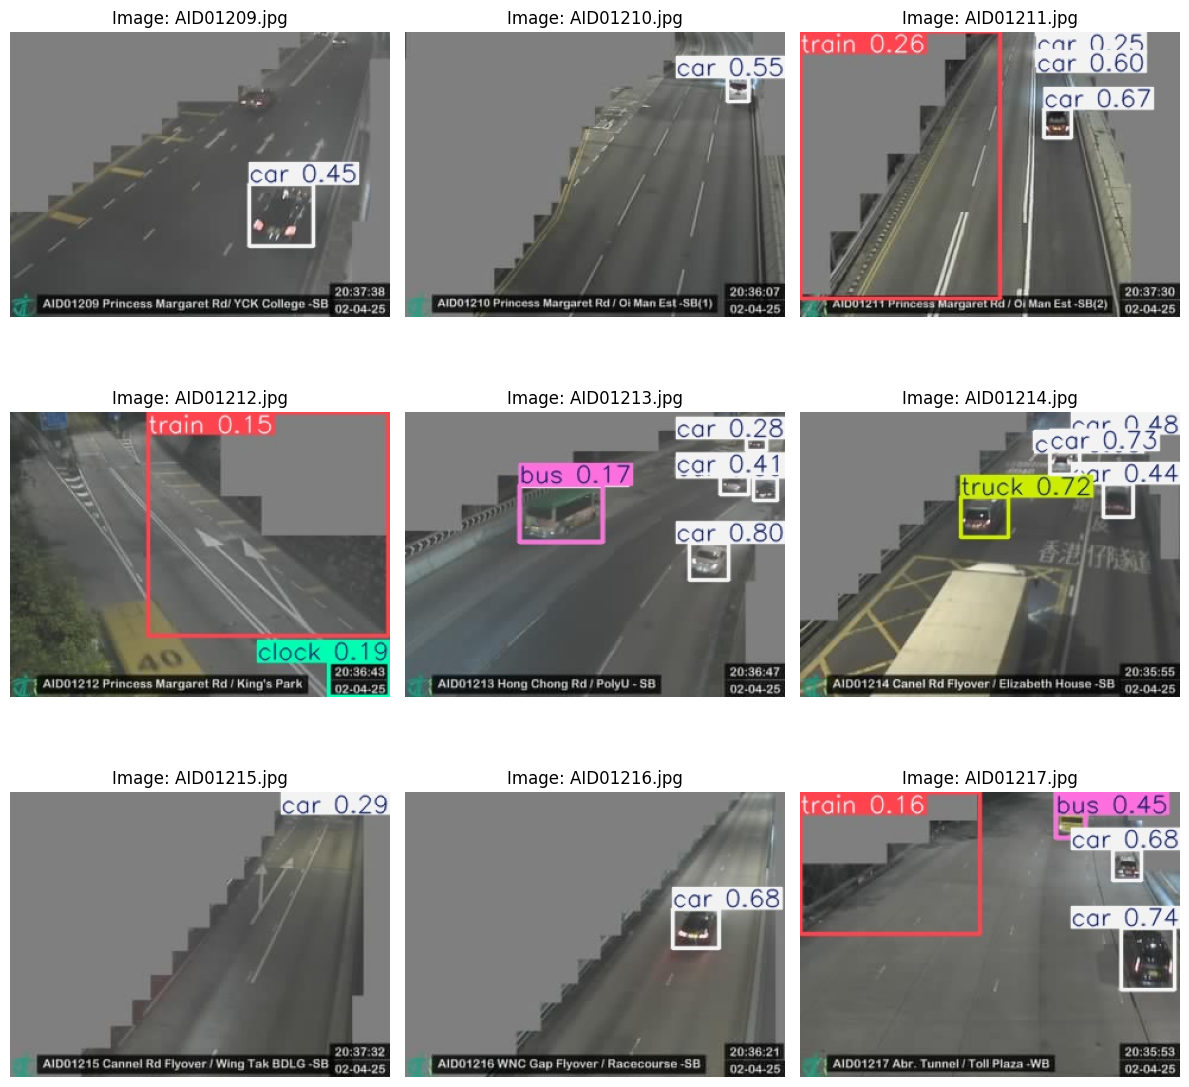

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Path to the processed images (detected images)
processed_images_dir = "dataset/detections"

# Get list of image files
image_files = [f for f in os.listdir(processed_images_dir) if f.endswith((".jpg", ".png"))]

# Set grid size (3x3)
rows, cols = 3, 3
num_images = len(image_files)

# Adjust grid if images are fewer than 9
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

# Loop through images and display in grid
for i, ax in enumerate(axes.flat):
    if i < num_images:
        img_path = os.path.join(processed_images_dir, image_files[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

        ax.imshow(img)
        ax.set_title(f"Image: {image_files[i]}")
        ax.axis("off")
    else:
        ax.axis("off")  

plt.tight_layout()
plt.show()